# **Modélisation statistique**
Nous allons mener des régressions linéaires de la production électrique éolienne (données API RTE) sur les données météorologiques de vents (données API ...)

Dans un premier temps, nous allons créer un data frame qui contiendra la moyenne nationale de la production électrique éolienne ainsi que la moyenne des vents nationaux, heure par heure pour l'année 2021.
Ensuite, nous affinerons l'analyse en faisant des régressions par région/année.

### **1) Récupération des données**

Dans un premier temps, nous cherchons à mettre les dates des données météorologique et des données RTE dans le même format. Le format cherché est, par exemple pour le 5 mai 2020 à 12h:

**2020-05-05:12:00**

#### **a) Données météorologiques**

In [1]:
import pandas as pd

In [46]:
donnees_vent = pd.read_csv(r'C:\Users\peign\Desktop\ProjetPython\donnees_vent.csv', sep=",", names=['Index', 'Time', 'Windspeed'])
donnees_vent_prediction = pd.read_csv(r'C:\Users\peign\Desktop\ProjetPython\donnees_vent_prediction.csv', sep=",", names=['Index', 'Time', 'Windspeed'])

In [42]:
donnees_vent.head()

,Index,Time,Windspeed
0,0,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86..."
1,1,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
2,2,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
3,3,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
4,12,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.66, 1.88, 1.97, 2.25, 1.43, 1.51, 1.43, 1.3..."


Le format des données est le suivant:

-L'index représente le numéro des éoliennes, numérotées de 0 à XXXX.

-La variable "Time" contient la liste de toutes les dates auxquelles on observe la vitesse du vent à la position de l'éolienne.

-La variable "Windspeed" contient la liste de la vitesse des vents.

Dans un premier temps, on va chercher à "nettoyer" la variable "Time" afin de créer une liste de dates harmonisées.

On va ajouter une colonne représentant la longueur du rotor de l'éolienne à partir de la précédente base de donnée.

In [3]:
df = pd.read_csv("eolien.csv", sep=";")

In [47]:
donnees_vent = donnees_vent.merge(df['diametre_rotor'],how = 'left',left_on = 'Index',right_index = True)
donnees_vent_prediction = donnees_vent.merge(df['diametre_rotor'],how = 'left',left_on = 'Index',right_index = True)

In [43]:
donnees_vent["Time"][0]

"['2021-01-01T00:00', '2021-01-01T01:00', '2021-01-01T02:00', '2021-01-01T03:00', '2021-01-01T04:00', '2021-01-01T05:00', '2021-01-01T06:00', '2021-01-01T07:00', '2021-01-01T08:00', '2021-01-01T09:00', '2021-01-01T10:00', '2021-01-01T11:00', '2021-01-01T12:00', '2021-01-01T13:00', '2021-01-01T14:00', '2021-01-01T15:00', '2021-01-01T16:00', '2021-01-01T17:00', '2021-01-01T18:00', '2021-01-01T19:00', '2021-01-01T20:00', '2021-01-01T21:00', '2021-01-01T22:00', '2021-01-01T23:00', '2021-01-02T00:00', '2021-01-02T01:00', '2021-01-02T02:00', '2021-01-02T03:00', '2021-01-02T04:00', '2021-01-02T05:00', '2021-01-02T06:00', '2021-01-02T07:00', '2021-01-02T08:00', '2021-01-02T09:00', '2021-01-02T10:00', '2021-01-02T11:00', '2021-01-02T12:00', '2021-01-02T13:00', '2021-01-02T14:00', '2021-01-02T15:00', '2021-01-02T16:00', '2021-01-02T17:00', '2021-01-02T18:00', '2021-01-02T19:00', '2021-01-02T20:00', '2021-01-02T21:00', '2021-01-02T22:00', '2021-01-02T23:00', '2021-01-03T00:00', '2021-01-03T01:00'

In [8]:
type(donnees_vent["Time"][0])

str

In [48]:
caracteres_time = ["'","[","]","T", ","]
    
for string in caracteres_time:
    donnees_vent["Time"] = donnees_vent["Time"].apply(lambda x: x.replace(string, ''))
    donnees_vent_prediction["Time"] = donnees_vent["Time"].apply(lambda x: x.replace(string, ''))    

In [10]:
donnees_vent["Time"][0]

'2021-01-0100:00 2021-01-0101:00 2021-01-0102:00 2021-01-0103:00 2021-01-0104:00 2021-01-0105:00 2021-01-0106:00 2021-01-0107:00 2021-01-0108:00 2021-01-0109:00 2021-01-0110:00 2021-01-0111:00 2021-01-0112:00 2021-01-0113:00 2021-01-0114:00 2021-01-0115:00 2021-01-0116:00 2021-01-0117:00 2021-01-0118:00 2021-01-0119:00 2021-01-0120:00 2021-01-0121:00 2021-01-0122:00 2021-01-0123:00 2021-01-0200:00 2021-01-0201:00 2021-01-0202:00 2021-01-0203:00 2021-01-0204:00 2021-01-0205:00 2021-01-0206:00 2021-01-0207:00 2021-01-0208:00 2021-01-0209:00 2021-01-0210:00 2021-01-0211:00 2021-01-0212:00 2021-01-0213:00 2021-01-0214:00 2021-01-0215:00 2021-01-0216:00 2021-01-0217:00 2021-01-0218:00 2021-01-0219:00 2021-01-0220:00 2021-01-0221:00 2021-01-0222:00 2021-01-0223:00 2021-01-0300:00 2021-01-0301:00 2021-01-0302:00 2021-01-0303:00 2021-01-0304:00 2021-01-0305:00 2021-01-0306:00 2021-01-0307:00 2021-01-0308:00 2021-01-0309:00 2021-01-0310:00 2021-01-0311:00 2021-01-0312:00 2021-01-0313:00 2021-01

In [11]:
donnees_vent["Windspeed"][0]

'[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86, 2.78, 2.86, 2.66, 3.0, 3.11, 3.36, 3.52, 3.14, 2.33, 1.61, 2.01, 1.8, 1.82, 2.0, 1.1, 0.58, 0.0, 0.45, 1.42, 1.42, 0.94, 1.12, 0.85, 0.81, 0.78, 0.64, 0.41, 0.91, 1.4, 1.81, 2.06, 1.93, 1.97, 2.48, 2.8, 2.51, 1.97, 1.49, 1.33, 1.84, 1.77, 1.25, 1.28, 1.39, 0.89, 1.25, 1.64, 1.88, 2.06, 2.47, 3.04, 3.71, 3.52, 3.57, 3.38, 3.27, 2.73, 2.56, 2.9, 3.18, 3.11, 2.9, 2.86, 2.72, 2.69, 2.66, 2.78, 2.64, 2.78, 2.82, 3.0, 2.92, 2.88, 2.97, 3.42, 3.85, 3.64, 3.35, 2.66, 2.76, 2.69, 2.58, 2.8, 3.06, 3.11, 2.78, 2.83, 2.95, 3.09, 3.28, 3.3, 3.08, 2.92, 2.73, 2.72, 2.63, 2.6, 2.92, 2.81, 3.61, 3.74, 3.76, 3.08, 2.52, 1.92, 1.84, 2.2, 2.42, 2.55, 2.42, 2.2, 2.11, 1.97, 1.8, 1.66, 1.57, 1.49, 1.55, 1.58, 1.52, 1.26, 1.61, 1.32, 2.11, 2.27, 2.14, 2.0, 1.39, 0.81, 1.12, 1.21, 1.5, 1.43, 1.14, 0.22, 0.1, 0.2, 0.2, 0.22, 0.58, 1.06, 1.08, 1.24, 0.85, 0.7, 1.14, 1.12, 1.25, 0.95, 1.48, 1.66, 1.42, 1.08, 1.32, 1.6, 1.8, 2.0, 1.91, 1.63, 1.61, 1.5, 1.9, 2.02, 

In [49]:
caracteres_vent = ["[", "]", ","]

for string in caracteres_vent:
    donnees_vent["Windspeed"] = donnees_vent["Windspeed"].apply(lambda x: x.replace(string, ''))
    donnees_vent_prediction["Windspeed"] = donnees_vent["Windspeed"].apply(lambda x: x.replace(string, ''))

In [13]:
donnees_vent["Windspeed"][0]

'1.43 1.25 1.7 2.02 2.08 2.42 2.64 2.86 2.78 2.86 2.66 3.0 3.11 3.36 3.52 3.14 2.33 1.61 2.01 1.8 1.82 2.0 1.1 0.58 0.0 0.45 1.42 1.42 0.94 1.12 0.85 0.81 0.78 0.64 0.41 0.91 1.4 1.81 2.06 1.93 1.97 2.48 2.8 2.51 1.97 1.49 1.33 1.84 1.77 1.25 1.28 1.39 0.89 1.25 1.64 1.88 2.06 2.47 3.04 3.71 3.52 3.57 3.38 3.27 2.73 2.56 2.9 3.18 3.11 2.9 2.86 2.72 2.69 2.66 2.78 2.64 2.78 2.82 3.0 2.92 2.88 2.97 3.42 3.85 3.64 3.35 2.66 2.76 2.69 2.58 2.8 3.06 3.11 2.78 2.83 2.95 3.09 3.28 3.3 3.08 2.92 2.73 2.72 2.63 2.6 2.92 2.81 3.61 3.74 3.76 3.08 2.52 1.92 1.84 2.2 2.42 2.55 2.42 2.2 2.11 1.97 1.8 1.66 1.57 1.49 1.55 1.58 1.52 1.26 1.61 1.32 2.11 2.27 2.14 2.0 1.39 0.81 1.12 1.21 1.5 1.43 1.14 0.22 0.1 0.2 0.2 0.22 0.58 1.06 1.08 1.24 0.85 0.7 1.14 1.12 1.25 0.95 1.48 1.66 1.42 1.08 1.32 1.6 1.8 2.0 1.91 1.63 1.61 1.5 1.9 2.02 2.02 2.04 1.84 2.02 2.28 2.39 1.49 1.66 1.93 2.31 2.4 2.24 1.6 2.25 2.41 2.22 1.84 2.01 2.15 1.88 1.75 1.91 1.9 1.84 1.66 1.78 2.47 2.83 3.28 3.54 3.96 3.8 4.19 4.6 6.46 5.

In [19]:
donnees_vent.head()

,Index,Time,Windspeed
0,0,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86..."
1,1,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
2,2,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
3,3,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
4,12,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[1.66, 1.88, 1.97, 2.25, 1.43, 1.51, 1.43, 1.3..."


Maintenant que les variables "Time" et "Windspeed" sont nettoyées, on va utiliser la fonction explode afin d'avoir une base de données "classique" pour pouvoir faire des régressions. Nous allons étendre les listes afin que chaque vent soit associé à une date précise.

Premièrement, on convertit nos données considérés comme "string" en liste.

In [50]:
donnees_vent["Time"] = donnees_vent["Time"].str.split(' ')
donnees_vent["Time"] = donnees_vent["Time"].tolist()

donnees_vent_prediction["Time"] = donnees_vent["Time"].str.split(' ')
donnees_vent_prediction["Time"] = donnees_vent["Time"].tolist()

In [51]:
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].str.split(' ')
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].tolist()

donnees_vent_prediction["Windspeed"] = donnees_vent["Windspeed"].str.split(' ')
donnees_vent_prediction["Windspeed"] = donnees_vent["Windspeed"].tolist()

In [17]:
donnees_vent.head()

,Index,Time,Windspeed
0,0,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86..."
1,1,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
2,2,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
3,3,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
4,12,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[1.66, 1.88, 1.97, 2.25, 1.43, 1.51, 1.43, 1.3..."


In [18]:
donnees_vent["Time"][0]

['2021-01-0100:00',
 '2021-01-0101:00',
 '2021-01-0102:00',
 '2021-01-0103:00',
 '2021-01-0104:00',
 '2021-01-0105:00',
 '2021-01-0106:00',
 '2021-01-0107:00',
 '2021-01-0108:00',
 '2021-01-0109:00',
 '2021-01-0110:00',
 '2021-01-0111:00',
 '2021-01-0112:00',
 '2021-01-0113:00',
 '2021-01-0114:00',
 '2021-01-0115:00',
 '2021-01-0116:00',
 '2021-01-0117:00',
 '2021-01-0118:00',
 '2021-01-0119:00',
 '2021-01-0120:00',
 '2021-01-0121:00',
 '2021-01-0122:00',
 '2021-01-0123:00',
 '2021-01-0200:00',
 '2021-01-0201:00',
 '2021-01-0202:00',
 '2021-01-0203:00',
 '2021-01-0204:00',
 '2021-01-0205:00',
 '2021-01-0206:00',
 '2021-01-0207:00',
 '2021-01-0208:00',
 '2021-01-0209:00',
 '2021-01-0210:00',
 '2021-01-0211:00',
 '2021-01-0212:00',
 '2021-01-0213:00',
 '2021-01-0214:00',
 '2021-01-0215:00',
 '2021-01-0216:00',
 '2021-01-0217:00',
 '2021-01-0218:00',
 '2021-01-0219:00',
 '2021-01-0220:00',
 '2021-01-0221:00',
 '2021-01-0222:00',
 '2021-01-0223:00',
 '2021-01-0300:00',
 '2021-01-0301:00',


In [13]:
donnees_vent

,Index,Time,Windspeed,diametre_rotor
0,0,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86...",53.0
1,1,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,...",82.0
2,2,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,...",82.0
3,3,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,...",82.0
4,12,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[1.66, 1.88, 1.97, 2.25, 1.43, 1.51, 1.43, 1.3...",60.0
...,...,...,...,...
3756,6876,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.43, 2.88, 2.82, 2.12, 2.19, 1.93, 1.46, 1.1...",92.0
3757,6877,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.6, 3.16, 2.67, 2.26, 2.21, 1.84, 1.5, 1.3, ...",92.0
3758,6878,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.6, 3.16, 2.67, 2.26, 2.21, 1.84, 1.5, 1.3, ...",92.0
3759,6879,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.6, 3.16, 2.67, 2.26, 2.21, 1.84, 1.5, 1.3, ...",92.0


In [52]:
donnees_vent = donnees_vent.set_index(['Index']).apply(pd.Series.explode).reset_index()

donnees_vent_prediction = donnees_vent_prediction.set_index(['Index']).apply(pd.Series.explode).reset_index()

In [10]:
donnees_vent

,Index,Time,Windspeed,diametre_rotor
0,0,2021-01-0100:00,1.43,53.0
1,0,2021-01-0101:00,1.25,53.0
2,0,2021-01-0102:00,1.7,53.0
3,0,2021-01-0103:00,2.02,53.0
4,0,2021-01-0104:00,2.08,53.0
...,...,...,...,...
32172091,6880,2021-12-3119:00,3.33,92.0
32172092,6880,2021-12-3120:00,2.48,92.0
32172093,6880,2021-12-3121:00,3.09,92.0
32172094,6880,2021-12-3122:00,3.2,92.0


In [53]:
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].astype(float)
donnees_vent["Index"] = donnees_vent["Index"].astype(str)

donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].astype(float)
donnees_vent_prediction["Index"] = donnees_vent_prediction["Index"].astype(str)

In [11]:
donnees_vent["rotor_carre"] = donnees_vent["diametre_rotor"].pow(2)

donnees_vent_prediction["rotor_carre"] = donnees_vent_prediction["diametre_rotor"].pow(2)

In [54]:
vent_moyen = donnees_vent.groupby(['Time']).mean()

vent_moyen_prediction = donnees_vent_prediction.groupby(['Time']).mean()

In [26]:
def weighted_average(group):
    d = group['rotor_carre']
    v = group['Windspeed']
    return (d*v).sum() / d.sum()

vent_moyen_pondéré = donnees_vent.groupby(['Time']).apply(weighted_average)

In [30]:
vent_moyen_pondéré = vent_moyen_pondéré.to_frame()

#### **b) Données RTE**
On importe les données RTE auparavant obtenu grâce à une API.

**Pour l'instant:** données test de Janvier à Février 2020

In [13]:
data_RTE = pd.read_csv('RTE_test.csv')

In [65]:
data_RTE

,Unnamed: 0,start_date,end_date,updated_date,value
0,0,2021-01-01 00:00:00+01:00,2021-01-01 01:00:00+01:00,2021-01-01T00:40:58+01:00,1082
1,1,2021-01-01 01:00:00+01:00,2021-01-01 02:00:00+01:00,2021-01-01T01:40:58+01:00,1075
2,2,2021-01-01 02:00:00+01:00,2021-01-01 03:00:00+01:00,2021-01-01T02:40:55+01:00,1086
3,3,2021-01-01 03:00:00+01:00,2021-01-01 04:00:00+01:00,2021-01-01T03:40:57+01:00,1149
4,4,2021-01-01 04:00:00+01:00,2021-01-01 05:00:00+01:00,2021-01-01T04:40:54+01:00,1170
...,...,...,...,...,...
3618,3618,2021-05-31 19:00:00+02:00,2021-05-31 20:00:00+02:00,2021-05-31T18:38:14+02:00,2304
3619,3619,2021-05-31 20:00:00+02:00,2021-05-31 21:00:00+02:00,2021-05-31T19:33:04+02:00,2316
3620,3620,2021-05-31 21:00:00+02:00,2021-05-31 22:00:00+02:00,2021-05-31T20:34:02+02:00,2845
3621,3621,2021-05-31 22:00:00+02:00,2021-05-31 23:00:00+02:00,2021-05-31T21:33:59+02:00,3840


On renomme les trois colonnes nécessaires et on enlève les colonnes inutiles

In [14]:
columns_to_drop = ['end_date', 'updated_date']
data_RTE = data_RTE.drop(columns_to_drop, axis=1)

columns_to_rename = {'Unnamed: 0': 'Index', 'start_date': 'Time', 'value': 'Electricity'}
data_RTE = data_RTE.rename(columns=columns_to_rename)

On enlève les éléments de la date inutile afin d'harmoniser

In [15]:
caracteres = ["+01:00"," ","+02:00"]
    
for string in caracteres:
    data_RTE["Time"] = data_RTE["Time"].apply(lambda x: x.replace(string, ''))

data_RTE["Time"] = data_RTE["Time"].str[:-3]

In [18]:
data_RTE

,Index,Time,Electricity
0,0,2021-01-0100:00,1082
1,1,2021-01-0101:00,1075
2,2,2021-01-0102:00,1086
3,3,2021-01-0103:00,1149
4,4,2021-01-0104:00,1170
...,...,...,...
3618,3618,2021-05-3119:00,2304
3619,3619,2021-05-3120:00,2316
3620,3620,2021-05-3121:00,2845
3621,3621,2021-05-3122:00,3840


Les dates sont bien au format harmonisé voulu.

#### **c) Merge des deux database**

In [46]:
vent_moyen_pondéré.columns = ['Weighted_Windspeed']

In [47]:
vent_moyen_pondéré

,Weighted_Windspeed
Time,
2021-01-0100:00,1.756002
2021-01-0101:00,1.803575
2021-01-0102:00,1.815039
2021-01-0103:00,1.802140
2021-01-0104:00,1.820984
...,...
2021-12-3119:00,3.201465
2021-12-3120:00,3.076979
2021-12-3121:00,3.076685


In [55]:
data = data_RTE.merge(vent_moyen, on='Time')
data["Windspeed_cubed"] = data["Windspeed"].pow(3)

In [48]:
data_pondéré = data_RTE.merge(vent_moyen_pondéré, on='Time')
data_pondéré["Windspeed_cubed"] = data_pondéré["Weighted_Windspeed"].pow(3)

In [49]:
data_pondéré

,Index,Time,Electricity,Weighted_Windspeed,Windspeed_cubed
0,0,2021-01-0100:00,1082,1.756002,5.414709
1,1,2021-01-0101:00,1075,1.803575,5.866820
2,2,2021-01-0102:00,1086,1.815039,5.979406
3,3,2021-01-0103:00,1149,1.802140,5.852824
4,4,2021-01-0104:00,1170,1.820984,6.038348
...,...,...,...,...,...
3618,3618,2021-05-3119:00,2304,2.643060,18.463797
3619,3619,2021-05-3120:00,2316,2.860375,23.402871
3620,3620,2021-05-3121:00,2845,3.016873,27.458151
3621,3621,2021-05-3122:00,3840,3.166412,31.746956


In [20]:
data

,Index,Time,Electricity,Windspeed,diametre_rotor,rotor_carre,Windspeed_cubed
0,0,2021-01-0100:00,1082,1.788180,88.467278,8131.771395,5.717860
1,1,2021-01-0101:00,1075,1.858877,88.467278,8131.771395,6.423208
2,2,2021-01-0102:00,1086,1.908737,88.467278,8131.771395,6.954058
3,3,2021-01-0103:00,1149,1.911929,88.467278,8131.771395,6.989009
4,4,2021-01-0104:00,1170,1.940669,88.467278,8131.771395,7.308943
...,...,...,...,...,...,...,...
3618,3618,2021-05-3119:00,2304,2.654525,89.101650,8256.422709,18.705126
3619,3619,2021-05-3120:00,2316,2.859386,89.101650,8256.422709,23.378599
3620,3620,2021-05-3121:00,2845,3.013519,89.101650,8256.422709,27.366655
3621,3621,2021-05-3122:00,3840,3.138568,89.101650,8256.422709,30.916804


### **2) Les régressions linéaires**

Dans un premier temps, on va regresser l'électricité produite sur le vent au cube afin de retrouver le coefficient $1/2 \rho S$ où $S = \pi/4 d^2$ est la surface de brassage de l'éolienne avec $d$ le diamètre du rotor. 

Ensuite on régressera le log de l'électricité produite sur le log du vent afin de retrouver le cube.

#### **a) Spécification de base: les vents ne sont pas pondérés**

In [43]:
import statsmodels.formula.api as smf

def regression_results(x, y, z):
    model = smf.ols(y+"~"+z, data=x).fit(cov_type='HC1')
    predictions = model.predict(x)
    print(model.summary())
    
regression_results(data, "Electricity", "Windspeed_cubed")  

                            OLS Regression Results                            
Dep. Variable:            Electricity   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     2139.
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:08:20   Log-Likelihood:                -31777.
No. Observations:                3623   AIC:                         6.356e+04
Df Residuals:                    3621   BIC:                         6.357e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2585.0433     47.384     

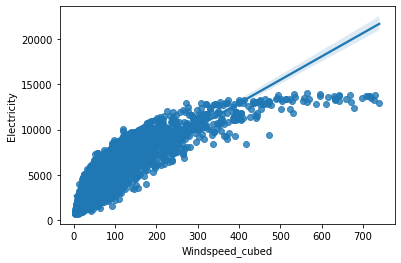

In [40]:
import seaborn as sns

def plot_linear_regression(x, y, z):
    plot = sns.regplot(x=z, y=y, data=x)
    return plot

plot = plot_linear_regression(data, "Electricity", "Windspeed_cubed")

#### **Deuxième régression: avec log**


In [53]:
import numpy as np
data['Electricity_log'] = np.log(data['Electricity'])
data['Windspeed_log'] = np.log(data['Windspeed'])

In [54]:
regression_results(data, "Electricity_log", "Windspeed_log")  

                            OLS Regression Results                            
Dep. Variable:        Electricity_log   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                 2.087e+04
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:32:15   Log-Likelihood:                -821.88
No. Observations:                3623   AIC:                             1648.
Df Residuals:                    3621   BIC:                             1660.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.9892      0.018    328.410

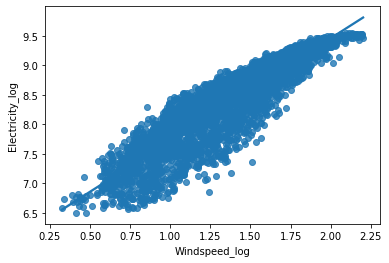

In [55]:
plot = plot_linear_regression(data, "Electricity_log", "Windspeed_log")

#### **b) Deuxième spécification : vents pondérés par le diamètre du rotor**
Je ne pense pas que ça change grand chose dans le fond

In [57]:
regression_results(data_pondéré, "Electricity", "Windspeed_cubed")  

                            OLS Regression Results                            
Dep. Variable:            Electricity   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1714.
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          4.85e-307
Time:                        14:32:36   Log-Likelihood:                -31885.
No. Observations:                3623   AIC:                         6.377e+04
Df Residuals:                    3621   BIC:                         6.379e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2718.5528     49.446     

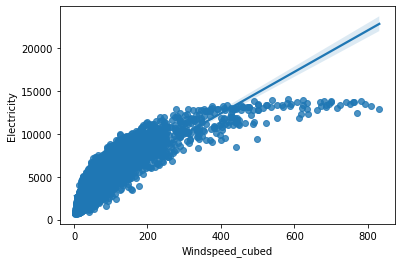

In [58]:
plot = plot_linear_regression(data_pondéré, "Electricity", "Windspeed_cubed")

In [61]:
data_pondéré['Electricity_log'] = np.log(data_pondéré['Electricity'])
data_pondéré['Windspeed_log'] = np.log(data_pondéré['Weighted_Windspeed'])

In [62]:
regression_results(data_pondéré, "Electricity_log", "Windspeed_log")  

                            OLS Regression Results                            
Dep. Variable:        Electricity_log   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                 2.070e+04
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:34:33   Log-Likelihood:                -796.17
No. Observations:                3623   AIC:                             1596.
Df Residuals:                    3621   BIC:                             1609.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.0608      0.018    340.118

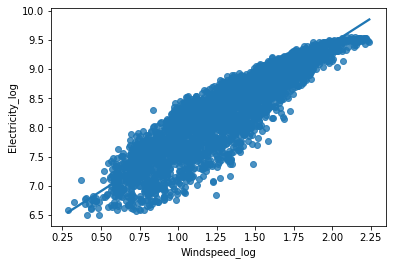

In [63]:
plot = plot_linear_regression(data_pondéré, "Electricity_log", "Windspeed_log")

#### **c) Troisième spécification : régression avec la cassure**

In [17]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [27]:
model = DecisionTreeRegressor(min_samples_leaf=10, max_depth=3)

X = data['Windspeed_cubed'].to_numpy()
X = X.reshape(-1, 1)

y = data['Electricity'].to_numpy()

model.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

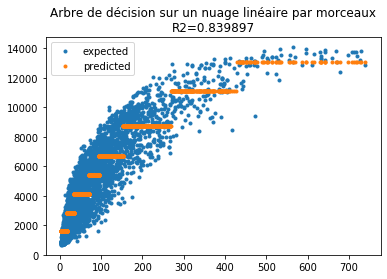

In [33]:
fig, ax = plt.subplots(1, 1)
ax.plot(X, y, ".", label="expected")
ax.plot(X, y_pred, ".", label="predicted")
ax.legend()
r2 = r2_score(y, y_pred)
ax.set_title("Arbre de décision sur un nuage linéaire par morceaux\nR2=%f" % r2);

#### **e) Cinquième spécification : masse volumique de l'air**

In [37]:
rho_air = 1.2

def calcul_energie(diametre_rotor,vitesse_vent):
    return 16/27/2 * rho_air * np.pi/4 * diametre_rotor**2 * np.power(vitesse_vent,3)

In [51]:
data['Energie'] = calcul_energie(data['diametre_rotor'],donnees_vent['Windspeed'])

#### **f) Régressions avec données prévisionnelles de vent (4 jours)**

#### **i) Lasso regression**

In [56]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso()
lasso_reg.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [57]:
vent_moyen_prediction["Windspeed_cubed"] = vent_moyen_prediction["Windspeed"].pow(3)

X_pred = vent_moyen_prediction['Windspeed_cubed'].to_numpy()
X_pred = X_pred.reshape(-1, 1)

y_pred_lasso = lasso_reg.predict(X_pred)

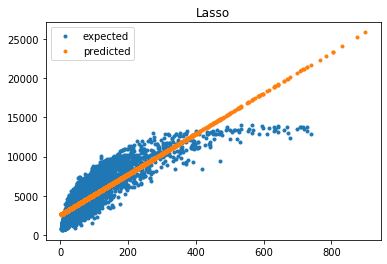

In [59]:
fig, lasso = plt.subplots(1, 1)
lasso.plot(X, y, ".", label="expected")
lasso.plot(X_pred, y_pred_lasso, ".", label="predicted")
lasso.legend()
lasso.set_title("Lasso");

#### **i) Ridge regression**

In [60]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
ridge_reg.fit(X, y)
y_pred_ridge = ridge_reg.predict(X_pred)

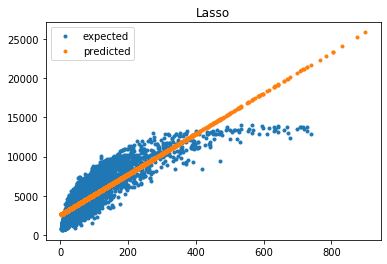

In [61]:
fig, ridge = plt.subplots(1, 1)
ridge.plot(X, y, ".", label="expected")
ridge.plot(X_pred, y_pred_lasso, ".", label="predicted")
ridge.legend()
ridge.set_title("Ridge");